# How to find and treat outliers using Python

In this notebook I will develop different techniques to detect and treat outliers in order to create examples for the following article published on Medium.

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Dataset

In this occasion I will use the 'tips' dataset that comes with the Seaborn library.

In [3]:
# Import seaborn 
import seaborn as sns

# Load tips dataset
taxis = sns.load_dataset('taxis')
taxis.head()

,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough
0,2019-03-23 20:21:09,2019-03-23 20:27:24,1,1.60,7.0,2.15,0.0,12.95,yellow,credit card,Lenox Hill West,UN/Turtle Bay South,Manhattan,Manhattan
1,2019-03-04 16:11:55,2019-03-04 16:19:00,1,0.79,5.0,0.00,0.0,9.30,yellow,cash,Upper West Side South,Upper West Side South,Manhattan,Manhattan
2,2019-03-27 17:53:01,2019-03-27 18:00:25,1,1.37,7.5,2.36,0.0,14.16,yellow,credit card,Alphabet City,West Village,Manhattan,Manhattan
3,2019-03-10 01:23:59,2019-03-10 01:49:51,1,7.70,27.0,6.15,0.0,36.95,yellow,credit card,Hudson Sq,Yorkville West,Manhattan,Manhattan
4,2019-03-30 13:27:42,2019-03-30 13:37:14,3,2.16,9.0,1.10,0.0,13.40,yellow,credit card,Midtown East,Yorkville West,Manhattan,Manhattan


## Univariate Outlier Detection

There are several techniques to identify outliers in a dataset, including visual inspection methods, statistical methods and even machine learning models such as the Local Outlier Factor (LOF), the Isolation Forest or the KNN algorithm.
However, for the case of univariate outliers, we can use statistical and visual inspection methods. In this article, I will explain the following:

* Histograms.
* Box plots.
* Z-score.
* Modified Z-score.
* Interquantile Range (IQR).

As a preliminary step, it is highly recommendable to use the 'describe()' method to get a quick overview of the data distribution and detect the presence of outliers in the dataset. In order to do this, we will look for noticeable differences between the minimum, mean and maximum values of the target variable. In this case, we will use the variable 'total', which indicates the total price of the taxi-ride.

In [4]:
taxis['total'].describe()

count    6433.000000
mean       18.517794
std        13.815570
min         1.300000
25%        10.800000
50%        14.160000
75%        20.300000
max       174.820000
Name: total, dtype: float64

The values are 1.3, 18.52 and 174.82 for the minimum, mean and maximum, respectively. The difference between the minimum and the maximum, and between the mean and the maximum value suggest that there may be outliers in the dataset. To confirm this suspicion we can use any of the following methods.

### Histogram

In [5]:
# Set an style for all charts
sns.set_style('darkgrid')

Text(0.5, 0, 'Total paid per trip')

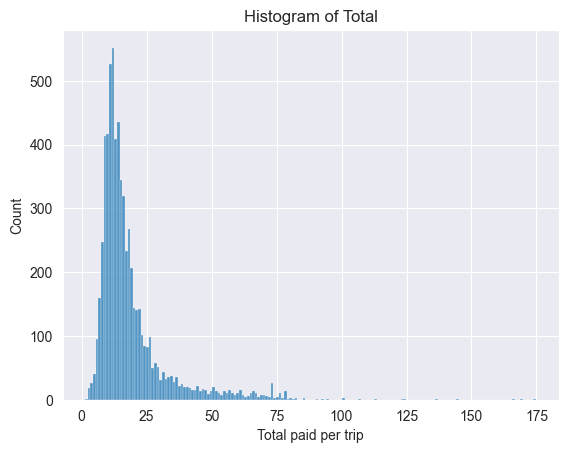

In [6]:
# Create a histogram using Seaborn
g = sns.histplot(data = taxis, x = 'total')

# Add labels
g.set_title('Histogram of Total')
g.set_xlabel('Total paid per trip')

## Box plot

Text(0.5, 0, 'Total paid per trip')

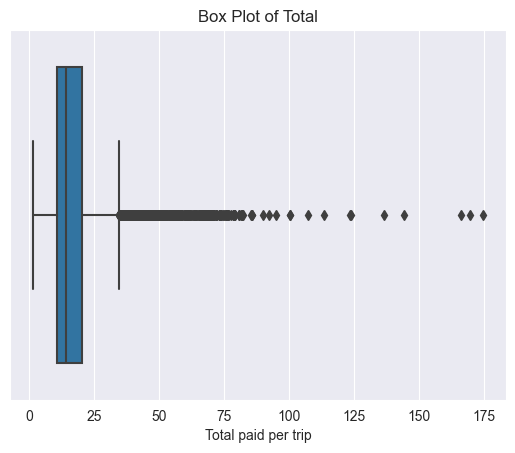

In [7]:
# Create a box plot 
g = sns.boxplot(data = taxis, x = 'total')

# Add a title and change xlabel
g.set_title('Box Plot of Total')
g.set_xlabel('Total paid per trip')

## Z-score

In [8]:
# Import zscore function
from scipy.stats import zscore

# Calculate z-score for each data point in the column and compute its absolute value
z_scores = zscore(taxis['total'])
abs_z_scores = np.abs(z_scores)

# Select the outliers using a threshold of 3
outliers = taxis[abs_z_scores > 3]

In [9]:
# Show result
outliers.head()

,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough
42,2019-03-30 23:59:14,2019-03-30 23:59:17,1,0.00,80.0,20.08,0.00,100.38,yellow,credit card,NaN,NaN,NaN,NaN
56,2019-03-05 17:57:00,2019-03-05 18:45:25,2,19.59,52.0,0.00,5.76,65.56,yellow,credit card,JFK Airport,Upper East Side North,Queens,Manhattan
162,2019-03-06 17:36:48,2019-03-06 18:43:39,2,17.10,52.0,13.10,5.76,78.66,yellow,credit card,Midtown South,JFK Airport,Manhattan,Queens
188,2019-03-26 15:06:47,2019-03-26 15:59:52,1,18.41,52.0,0.02,5.76,61.08,yellow,credit card,JFK Airport,Midtown Center,Queens,Manhattan
225,2019-03-22 15:36:34,2019-03-22 16:34:48,2,12.07,48.5,11.51,5.76,69.07,yellow,credit card,Manhattan Valley,Boerum Hill,Manhattan,Brooklyn


In [10]:
# Obtain number of outliers
print(f'Number of outliers: {len(outliers)}')

Number of outliers: 185


## Modified Z-score

The scipy function median_abs_deviation allows us to calculate the absolute deviation of the median (MAD), which we can then insert into the formula to obtain the modified z-score for each data point.

In [11]:
# Import the median_abs_deviation function
from scipy.stats import median_abs_deviation

# Obtain the MAD value 
mad_score = median_abs_deviation(taxis['total'])
mad_score

4.199999999999999

We can also do it manually with the following code, the result is the same.

In [12]:
# Find the median
median = taxis['total'].median()

# Find the absolute value of differences between the median and each data point
abs_diffs = (taxis['total'] - median).abs()

# Take the median of differences
mad_score = abs_diffs.median()
mad_score

4.199999999999999

However, this formula is already implemented as the MAD estimator in the PyOD library, so there is no need to perform the above calculation. We can use it as follows:

In [13]:
# Import MAD estimator
from pyod.models.mad import MAD

# Set threshold to 3.5
mad = MAD(threshold = 3.5)

# Convert the 'total' column into a 2D numpy array
total_reshaped = taxis['total'].values.reshape(-1, 1)

# Generate inline and outlier labels
labels = mad.fit(total_reshaped).labels_
labels

array([0, 0, 0, ..., 0, 0, 0])

In [14]:
# Obtain number of outliers
print(f'Number of outliers: {labels.sum()}')

Number of outliers: 560


In [15]:
outliers = taxis[labels == 1]
outliers.head()

,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough
3,2019-03-10 01:23:59,2019-03-10 01:49:51,1,7.70,27.0,6.15,0.00,36.95,yellow,credit card,Hudson Sq,Yorkville West,Manhattan,Manhattan
22,2019-03-28 17:20:54,2019-03-28 17:55:57,1,9.82,31.5,8.31,5.76,49.87,yellow,credit card,LaGuardia Airport,Sutton Place/Turtle Bay North,Queens,Manhattan
40,2019-03-07 15:15:46,2019-03-07 15:50:14,1,7.51,27.0,6.06,0.00,36.36,yellow,credit card,Flatiron,Carroll Gardens,Manhattan,Brooklyn
42,2019-03-30 23:59:14,2019-03-30 23:59:17,1,0.00,80.0,20.08,0.00,100.38,yellow,credit card,NaN,NaN,NaN,NaN
53,2019-03-20 18:49:24,2019-03-20 19:12:40,1,13.45,36.0,0.00,0.00,37.80,yellow,cash,JFK Airport,Sunnyside,Queens,Queens


## IQR

In [16]:
# Calculate the percentiles
seventy_fifth = taxis['total'].quantile(0.75)
twenty_fifth = taxis['total'].quantile(0.25)

# Obtain IQR
iqr = seventy_fifth - twenty_fifth

# Upper and lower thresholds
upper = seventy_fifth + (1.5 * iqr)
lower = twenty_fifth - (1.5 * iqr)

# Subset the dataset 
outliers = taxis[(taxis['total'] < lower) | (taxis['total'] > upper)]
outliers.head()

,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough
3,2019-03-10 01:23:59,2019-03-10 01:49:51,1,7.70,27.0,6.15,0.00,36.95,yellow,credit card,Hudson Sq,Yorkville West,Manhattan,Manhattan
22,2019-03-28 17:20:54,2019-03-28 17:55:57,1,9.82,31.5,8.31,5.76,49.87,yellow,credit card,LaGuardia Airport,Sutton Place/Turtle Bay North,Queens,Manhattan
40,2019-03-07 15:15:46,2019-03-07 15:50:14,1,7.51,27.0,6.06,0.00,36.36,yellow,credit card,Flatiron,Carroll Gardens,Manhattan,Brooklyn
42,2019-03-30 23:59:14,2019-03-30 23:59:17,1,0.00,80.0,20.08,0.00,100.38,yellow,credit card,NaN,NaN,NaN,NaN
43,2019-03-27 19:39:16,2019-03-27 20:00:26,1,9.50,28.0,0.00,5.76,35.06,yellow,cash,LaGuardia Airport,Washington Heights South,Queens,Manhattan


In [17]:
# Obtain number of outliers
print(f'Number of outliers: {len(outliers)}')

Number of outliers: 600


# How to treat outliers

## Remove

In [18]:
taxis_filtered = taxis.copy()
taxis_filtered = taxis_filtered[labels == 0]

## Imputation

In [20]:
# Calculate the median
median_value = taxis['total'].median()

# Impute outliers with the median
taxis_imputed = taxis.copy()
taxis_imputed.loc[outliers.index, 'total'] = median_value

## Winsorization

In [22]:
from scipy.stats.mstats import winsorize

taxis_winsorized = taxis.copy()
taxis_winsorized['Total'] = winsorize(taxis_winsorized['total'], limits = [0.05, 0.05], inplace = True)

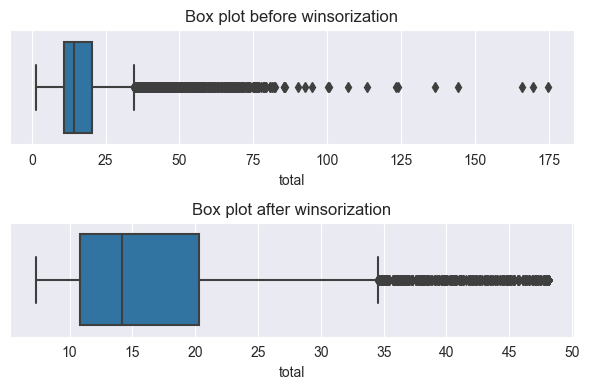

In [23]:
# Create a fig and axis for a 2x1 grid

fig, axes = plt.subplots(2, 1, figsize = (6, 4))

#  Create a box plot before and after winsorization
sns.boxplot(data = taxis, x = 'total', ax = axes[0])
sns.boxplot(data = taxis_winsorized, x = 'total', ax = axes[1])

# Add labels and titles to each plot
axes[0].set_title('Box plot before winsorization')
axes[1].set_title('Box plot after winsorization')

plt.tight_layout()